In [1]:
from IPython.display import HTML

HTML('''
<script>code_show=true; 

function code_toggle() {
    if (code_show){
    $('div.input').hide();
    } else {
    $('div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to show or hide your raw code."></form>
''')

# The MNIST Problem

The MNIST database (Modified National Institute of Standards and Technology database[1]) is a large database of handwritten digits that is commonly used for training and testing advanced machine learning algorithms. General references are:

**MNIST database**. Wikipedia. https://en.wikipedia.org/wiki/MNIST_database.

**THE MNIST DATABASE of handwritten digits**. Yann LeCun, Courant Institute, NYU Corinna Cortes, Google Labs, New York Christopher J.C. Burges, Microsoft Research, Redmond. http://yann.lecun.com/exdb/mnist/

**Classification datasets results**. Rodrigo Benenson. https://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html

The MNIST database contains 60,000 training images and 10,000 testing images. In our dataset the images will be 32 x 32 greyscale digit rasters.
In order to manage our computations in reasonable time, we are going to build our models working only with the test subset, which you can also further randomly split into train-validation and test subsets. If possible, you can also use the original train subset as a test one.

Do that taking into account you computing environment, but also trying to get models as good as possible.

### Student contributions

* Student `Herraez` has ...
* Student `Peman` has ...

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import time
import pickle
import gzip

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_auc_score

from sklearn.pipeline import Pipeline

from sklearn.svm import SVC


np.random.seed(1)

## Loading Data

There are several ways of getting the MNIST dataset. A simple one is to import it from the Keras library:

`from keras.datasets import mnist`  
`from matplotlib import pyplot`
 
`(train_X, train_y), (test_X, test_y) = mnist.load_data()`

We are going to use another version where the shape of each pattern is given by a $32 \times 32 \times 1$ tensor, as the original $28 \times 28$ images have been 0 padded. Thus, you may have to reshape it to either a matrix or a vector depending on the task you want to perform.

In [4]:
f_bnch = r"C:\Users\Javier\Documents\masterAFI\15. Aprendizaje supervisado II\content\mnist_32_32.bnch.joblib"
mnist = joblib.load(f_bnch)
print(mnist.keys())

print("data_shape: {0}".format(mnist['data'].shape))
print("data_test_shape: {0}".format(mnist['data_test'].shape))

dict_keys(['DESCR', 'target', 'target_test', 'data', 'data_test'])
data_shape: (60000, 1024)
data_test_shape: (10000, 1024)


## Data Exploration, Visualization and Correlations

Descriptive statistics, boxplots and histograms.

### Some examples

Plot 10 randomly chosen digit images as 5 x 2 subplots.

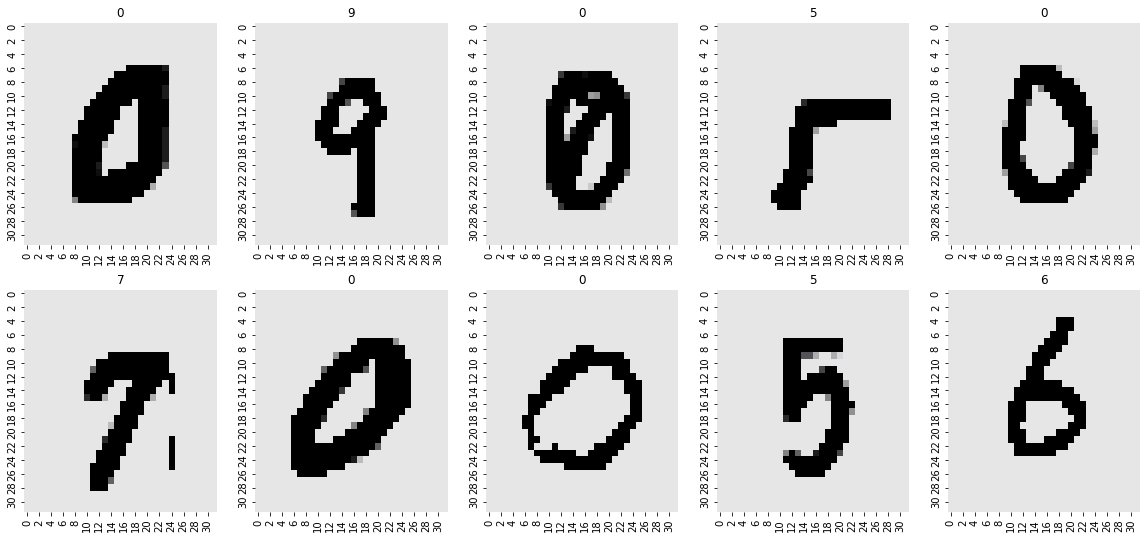

In [5]:
cMap = sns.cubehelix_palette(n_colors=50, hue=0.05, rot=0, light=0.9, dark=0)

l_columns = mnist['data']
plt.figure(figsize=(20, 9))

for i in range(10):
    plt.subplot(2, 5, i+1)
    #select images randomly
    idx = np.random.randint(low=0, high=mnist['data'].shape[0])
    plt.title(int(mnist['target'][idx]))
    h_map = sns.heatmap(mnist['data'][idx].reshape(32, 32),
                    vmin=0., vmax=16., 
                    cmap=cMap, 
                    cbar=False,
                    #annot=True, 
                   )
plt.show()

### Descriptive analysis

Build a DataFrame to make easier the exploratory analysis.

In [6]:
df = pd.DataFrame(data=mnist['data'], columns=range(0, mnist['data'].shape[1]))
df

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Describe the basic statistics of the pixels on the positions in the range `[494 : 502]` of the reshaped patterns.

In [7]:
df[df.columns[494 : 502]].describe(include='all').round(decimals=2).T

,count,mean,std,min,25%,50%,75%,max
494,60000.0,86.87,106.35,0.0,0.0,6.0,211.0,255.0
495,60000.0,96.97,108.72,0.0,0.0,29.0,232.0,255.0
496,60000.0,111.37,113.81,0.0,0.0,64.0,252.0,255.0
497,60000.0,123.97,111.61,0.0,0.0,123.0,252.0,255.0
498,60000.0,129.81,109.95,0.0,0.0,141.0,252.0,255.0
499,60000.0,126.60,112.15,0.0,0.0,132.0,252.0,255.0
500,60000.0,108.88,111.55,0.0,0.0,64.0,251.0,255.0
501,60000.0,81.16,104.69,0.0,0.0,0.0,195.0,255.0


### Boxplots

Compute and display the boxplots of pixels in the range `[494 : 502]`.

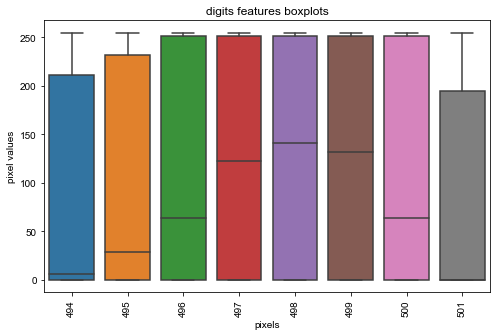

In [8]:
plt.figure( figsize=(8, 5))
plt.title("digits features boxplots")
sns.set_style("white")
bx_plot = sns.boxplot(data=df[df.columns[494 : 502]])
plt.xticks(rotation=90)
plt.xlabel("pixels")
plt.ylabel("pixel values")
plt.show()

### Histograms and scatterplots

Plot pairplots and histograms over the previous pixel range using `sns.pairplot`.  
To do so select first two target digits which you may think should be quite different (e.g., 6 and 7) and apply `pairplot` only on patterns from those two targets.

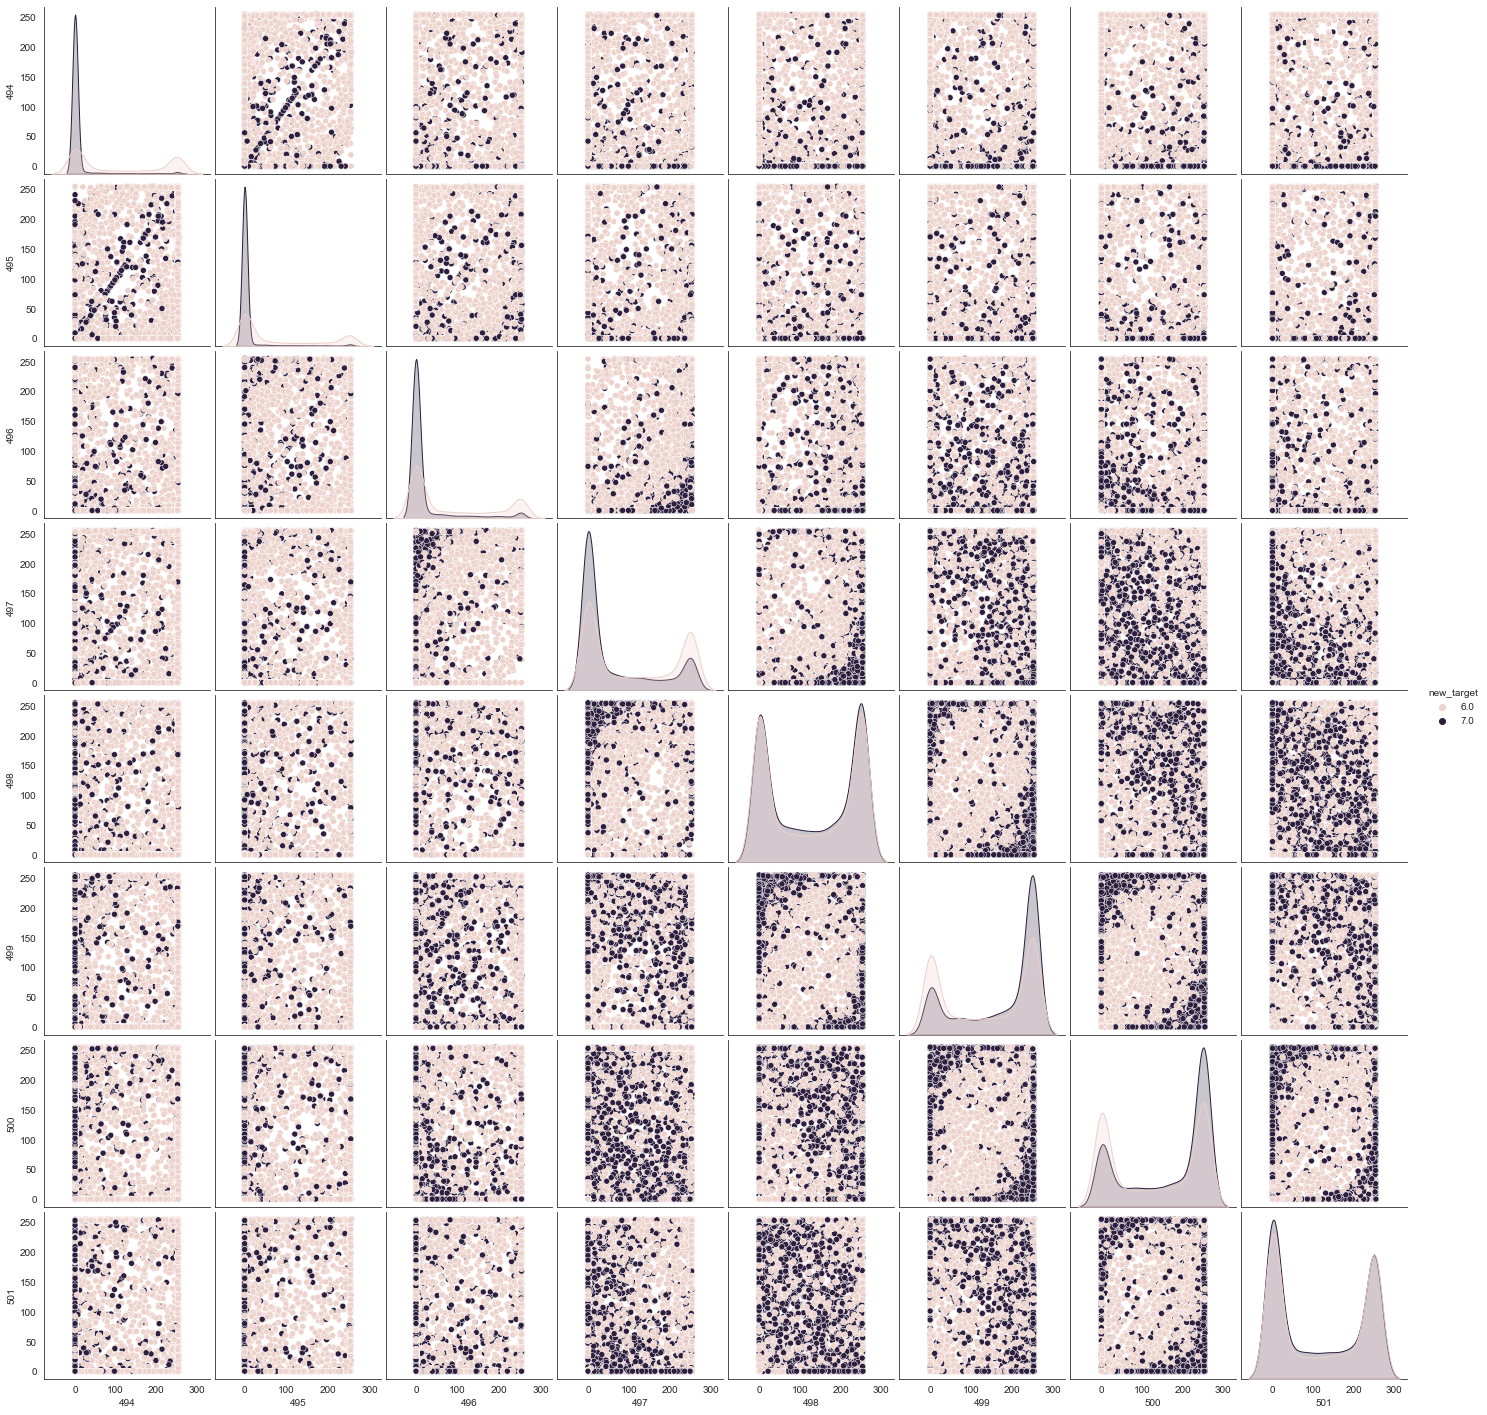

In [9]:
target_digit_6, target_digit_7 = 6, 7
new_targets = np.zeros(mnist['target'].shape[0])
new_targets[mnist['target'] == target_digit_6] = 6
new_targets[mnist['target'] == target_digit_7] = 7
df['new_target'] = new_targets
l_columns = list(range(494, 502))

df_aux = df[(df['new_target'] == 6) | (df['new_target'] == 7)][l_columns + ['new_target']]

pair_plot = sns.pairplot(df_aux, hue= 'new_target', diag_kind="kde", diag_kws=dict(shade=True))
plt.show()

### Correlations

Use the previous digit selection and pixel range but drop the `target` column.

Use directly a heatmap to display the correlations.

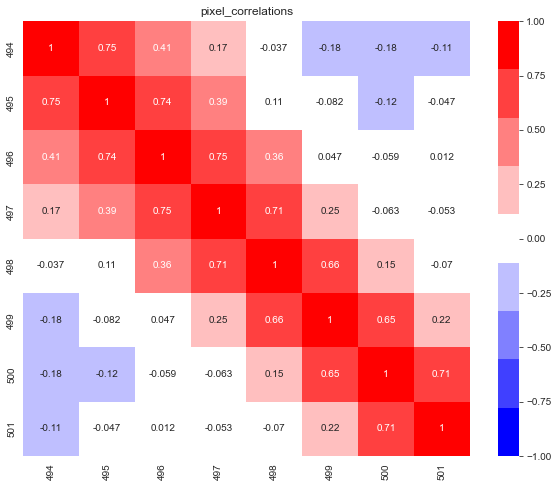

In [10]:
n_colors = 9
cMap = plt.cm.get_cmap("bwr",lut=n_colors ) 

plt.figure( figsize=(10, 8))
plt.title('pixel_correlations')
h_map = sns.heatmap(df_aux[l_columns].corr().values,
                    vmin=-1., vmax=1., 
                    cmap=cMap, 
                    annot=True, 
                    xticklabels=list(df_aux[l_columns]),
                    yticklabels=list(df_aux[l_columns]))
plt.xticks(rotation=90) 

plt.show()

### Data Analysis Conclusions

Gracias al análisis exploratorio realizado no podemos hacer grandes conclusiones. Sin embargo, podemos hacer algunas anotaciones. Parece ser que la mayoría de píxeles van a tener como valor el 0, además de tener gran correlación entre aquellos que son próximos. A destacar, podemos observar que existen diversos píxeles que pueden ser de gran utilidad para disitinguir unos números de otros, como hemos visto con el 6 y el 7.

# Classiffiers

We are going to build an MLP classifier **over the test dataset**.  
But before working with any classifier, we split first the test dataset into a train-validation and a test subset.  
Use for this the class `StratifiedShuffleSplit` from scikit-learn. Set the `test_size` parameter to either `0.5` or `0.75`.

### Splitting the test dataset

In [11]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.75)
for train_index, test_index in sss.split(mnist['data_test'], mnist['target_test']):
  X_train, X_test = mnist['data_test'][train_index], mnist['data_test'][test_index]
  y_train, y_test = mnist['target_test'][train_index], mnist['target_test'][test_index]

## MLP Classifier

### CV Hyperparametrization

Define an appropriate `MLPClassifier` and discuss in some detail your choices of the `MLPClassifier` parameters to ensure a proper convergence.

Then, perform CV to select proper `alpha` and `hidden_layer_sizes` hyperparameters.

In [12]:
std_sc = StandardScaler()
X_train = std_sc.fit_transform(X_train)

In [13]:
n_folds = 5
skf = StratifiedKFold(n_folds, shuffle=True)

l_hidden_layer_sizes = [(20,), (20, 20), (20, 20, 20)]
l_alpha = [10.**k for k in range(-6, 4)]

param_grid = {'mlp__alpha': l_alpha, 'mlp__hidden_layer_sizes': l_hidden_layer_sizes}

mlp_c = MLPClassifier(solver='lbfgs', 
                      activation='relu',
                      tol=1.e-4, 
                      max_iter=1000,
                      warm_start=False,
                      shuffle=True)

inner_estimator = Pipeline(steps=[('std_sc', StandardScaler()),
                                  ('mlp', mlp_c)])

cv_estimator_0 = GridSearchCV(inner_estimator, 
                              param_grid=param_grid, 
                              cv=skf, 
                              scoring='accuracy', 
                              return_train_score=True, 
                              n_jobs=-1, 
                              verbose=1)

t_0 = time.time() 
_ = cv_estimator_0.fit(X_train, y_train)
t_1 = time.time() 
print("\nmlp_grid_search_time: %.2f" % ((t_1 - t_0)/60.))
        
 
f = gzip.open('mlp_cl_alpha_search_results.pkz', mode='wb', compresslevel=9)
pickle.dump(cv_estimator_0, f, protocol=3)
f.close()

Fitting 5 folds for each of 30 candidates, totalling 150 fits

mlp_grid_search_time: 6.53


c:\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


El mensaje de warning, se puede deber a alguno de los valores en los extremos de los hiperparámetros. Hemos intentado aumentar el número de iteraciones, pero el tiempo de entrenamiento en nuestro PC era excesivo. 

### Search Results 

We first examine the test scores of the 5 best hyperparameters.

In [14]:
df_cv_estimator = pd.DataFrame.from_dict(cv_estimator_0.cv_results_)

display(df_cv_estimator[["param_mlp__alpha", "param_mlp__hidden_layer_sizes", "mean_test_score"]].sort_values(by="mean_test_score", ascending=False).head())

,param_mlp__alpha,param_mlp__hidden_layer_sizes,mean_test_score
21,10.0,"(20,)",0.9204
19,1.0,"(20, 20)",0.9128
20,1.0,"(20, 20, 20)",0.9120
18,1.0,"(20,)",0.9116
22,10.0,"(20, 20)",0.9104


We analyze the CV results to check whether the CV ranges used are correct.

best alpha: 10.000000	
alpha_min: 0.000001	alpha_max: 1000.000000
best_hidden_layer_sizes (20,) 
acc: 0.920


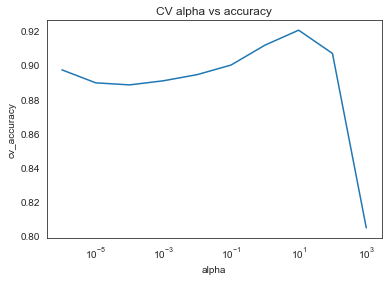

In [15]:
f = gzip.open('mlp_cl_alpha_search_results.pkz', mode='rb')
cv_estimator_0 = pickle.load(f)
f.close()

best_alpha = cv_estimator_0.best_params_['mlp__alpha'] 
print("best alpha: %.6f\t" % best_alpha)
print("alpha_min: %f\talpha_max: %f" % (np.array(l_alpha).min(), np.array(l_alpha).max()))

best_hidden_layer_sizes = cv_estimator_0.best_params_['mlp__hidden_layer_sizes'] 
print("best_hidden_layer_sizes", best_hidden_layer_sizes, "\nacc: %.3f" % cv_estimator_0.best_score_) 

idx_best_hidden_layer_sizes = [tup == best_hidden_layer_sizes for tup in df_cv_estimator['param_mlp__hidden_layer_sizes'].values]
idx_best_hidden_layer_sizes = np.array(idx_best_hidden_layer_sizes)

plt.title("CV alpha vs accuracy")
plt.xscale('log')
plt.xlabel("alpha")
plt.ylabel("cv_accuracy")
_ = plt.plot( df_cv_estimator[idx_best_hidden_layer_sizes]['param_mlp__alpha'], 
              df_cv_estimator[idx_best_hidden_layer_sizes]['mean_test_score'])

El mejor accuracy utiliza el alfa que se ecuentra dentro del rango que nostros hemos introducido. Sin embargo, podemos optimizar aún más este parámetro, cosa que hacemos a continuación:

In [16]:
l_hidden_layer_sizes = [(20,), (20, 20), (20, 20, 20)]
l_alpha = [best_alpha * 2.**k for k in range(-5, 4)]

param_grid = {'mlp__alpha': l_alpha, 'mlp__hidden_layer_sizes': l_hidden_layer_sizes}

cv_estimator_1 = GridSearchCV(inner_estimator, 
                              param_grid=param_grid, 
                              cv=skf, 
                              scoring='accuracy', 
                              return_train_score=True,
                              n_jobs=-1, 
                              verbose=1)

_ = cv_estimator_1.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


c:\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [17]:
df_cv_estimator = pd.DataFrame.from_dict(cv_estimator_1.cv_results_)

display(df_cv_estimator[["param_mlp__alpha", "param_mlp__hidden_layer_sizes", "mean_test_score"]].sort_values(by="mean_test_score", ascending=False).head())

,param_mlp__alpha,param_mlp__hidden_layer_sizes,mean_test_score
18,20.0,"(20,)",0.9224
13,5.0,"(20, 20)",0.9208
9,2.5,"(20,)",0.9208
15,10.0,"(20,)",0.9204
19,20.0,"(20, 20)",0.9192


best alpha: 20.000000	
alpha_min: 0.312500	alpha_max: 80.000000
best_hidden_layer_sizes (20,) 
acc: 0.922


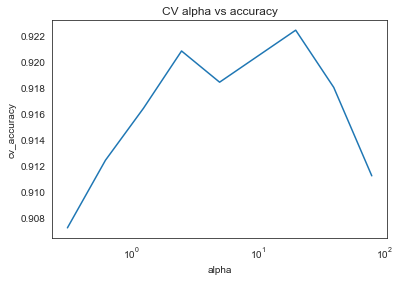

In [18]:
best_alpha = cv_estimator_1.best_params_['mlp__alpha'] 
print("best alpha: %.6f\t" % best_alpha)
print("alpha_min: %f\talpha_max: %f" % (np.array(l_alpha).min(), np.array(l_alpha).max()))

best_hidden_layer_sizes = cv_estimator_1.best_params_['mlp__hidden_layer_sizes'] 
print("best_hidden_layer_sizes", best_hidden_layer_sizes, "\nacc: %.3f" % cv_estimator_1.best_score_) 

idx_best_hidden_layer_sizes = [tup == best_hidden_layer_sizes for tup in df_cv_estimator['param_mlp__hidden_layer_sizes'].values]
idx_best_hidden_layer_sizes = np.array(idx_best_hidden_layer_sizes)

plt.title("CV alpha vs accuracy")
plt.xscale('log')
plt.xlabel("alpha")
plt.ylabel("cv_accuracy")
_ = plt.plot( df_cv_estimator[idx_best_hidden_layer_sizes]['param_mlp__alpha'], 
              df_cv_estimator[idx_best_hidden_layer_sizes]['mean_test_score'])

### Test MLPC Performance

We check the test accuracy and confusion matrix.

In [19]:
y_pred = cross_val_predict(cv_estimator_1.best_estimator_, X_test, y_test, cv=skf, n_jobs=-1)

best_alpha = cv_estimator_1.best_params_['mlp__alpha'] 
print("best alpha: %.6f\t" % best_alpha)

acc    = accuracy_score(y_test, y_pred)

print("acc: %.3f" % (acc))

print("\nconfusion matrix:\n", confusion_matrix(y_test, y_pred))

best alpha: 20.000000	
acc: 0.940

confusion matrix:
 [[715   0   0   2   1   3   8   1   4   1]
 [  0 837   4   2   1   2   1   1   3   0]
 [  5   3 719   6   8   1   8  15   9   0]
 [  1   0  11 700   0  13   3  11  10   8]
 [  0   0   6   0 701   0   8   2   2  18]
 [  7   1   1  17   3 618   7   4   8   3]
 [  6   1   4   0   5   7 693   0   3   0]
 [  6  10  12   5   8   1   0 709   1  19]
 [  7   5   3  16   8   9   5   9 659   9]
 [  9   4   2   9  20   3   0   8   6 696]]


### Conclusions on the MLP classifier

Give here a discussion as complete as possible of your results 

## SVC Classifier

### CV Hyperparametrization

Define an appropriate `SVC` model and discuss in some detail your choices of the `SVC` parameters to ensure a proper convergence.

Then, perform CV to select proper `C` and `gamma` hyperparameters.

In [20]:

n_folds = 5
skf = StratifiedKFold(n_folds, shuffle=True)

svc = SVC(kernel='rbf',
        shrinking=False,
        decision_function_shape='ovr',
        tol=1.e-3
         )

svc_classifier = Pipeline(steps=[('std_sc', StandardScaler()),
                                 ('svc', svc)])

l_C = [10.**k for k in range(0, 5)]
l_gamma = [2.**k for k in range(-6, -2)]

param_grid = {'svc__C': l_C, 'svc__gamma': l_gamma}

svc_gscv = GridSearchCV(svc_classifier, 
                        param_grid=param_grid, 
                        cv=skf, 
                        #scoring='roc_auc', 
                        scoring='accuracy', 
                        return_train_score=True, 
                        n_jobs=-1, 
                        verbose=1)

t_0 = time.time() 
#_ = svc_classifier.fit(x, y)
_ = svc_gscv.fit(X_train, y_train)
t_1 = time.time() 
print("\nmlp_grid_search_time: {0:.2f}m".format((t_1 - t_0)/60.))

Fitting 5 folds for each of 20 candidates, totalling 100 fits

mlp_grid_search_time: 13.08m


Hemos puesto **shrinking=False**, porque no queremos arriesgarnos a que se dejen de utilizar puntos útiles en el entrenamiento, ya que tenemos tiempo suficiente para entrenar.

In [21]:
f_pkl = open("c_gamma_cv_search_mnist.plk", 'wb') 
pickle.dump(svc_gscv, f_pkl)
f_pkl.close()

### Search Results 

We first examine the test scores of the 5 best hyperparameters.

In [22]:
df_cv_estimator = pd.DataFrame.from_dict(svc_gscv.cv_results_)
df_params = df_cv_estimator[["param_svc__C", "param_svc__gamma", "mean_test_score"]]
display(df_params.sort_values(by="mean_test_score", ascending=False).head())

,param_svc__C,param_svc__gamma,mean_test_score
12,1000.0,0.015625,0.5704
4,10.0,0.015625,0.5704
16,10000.0,0.015625,0.5704
8,100.0,0.015625,0.5704
0,1.0,0.015625,0.5368


We analyze the CV results to check whether the CV ranges used are correct.

Hemos observado que la mejor gamma era el mínimo valor posible para los 5 mejotes modelos, y, por tanto, hemos decidio modificar el rango de la gamma, desde 2 elevado a -12 hasta 2 elevado a -6.

In [23]:

n_folds = 5
skf = StratifiedKFold(n_folds, shuffle=True)

svc = SVC(shrinking=False, 
          decision_function_shape='ovr'
          )

svc_classifier = Pipeline(steps=[('std_sc', StandardScaler()),
                                 ('svc', svc)])

l_C = [10.**k for k in range(0, 5)]
l_gamma = [2.**k for k in range(-12, -6)]

param_grid = {'svc__C': l_C, 'svc__gamma': l_gamma}

svc_gscv = GridSearchCV(svc_classifier, 
                        param_grid=param_grid, 
                        cv=skf, 
                        #scoring='roc_auc', 
                        scoring='accuracy', 
                        return_train_score=True, 
                        n_jobs=-1, 
                        verbose=1)

t_0 = time.time() 
_ = svc_gscv.fit(X_train, y_train)
t_1 = time.time() 
print("\nmlp_grid_search_time: {0:.2f}m".format((t_1 - t_0)/60.))

Fitting 5 folds for each of 30 candidates, totalling 150 fits

mlp_grid_search_time: 9.97m


In [24]:
df_cv_estimator = pd.DataFrame.from_dict(svc_gscv.cv_results_)
df_params = df_cv_estimator[["param_svc__C", "param_svc__gamma", "mean_test_score"]]
display(df_params.sort_values(by="mean_test_score", ascending=False).head())

,param_svc__C,param_svc__gamma,mean_test_score
7,10.0,0.000488,0.9212
13,100.0,0.000488,0.9208
19,1000.0,0.000488,0.9208
25,10000.0,0.000488,0.9208
6,10.0,0.000244,0.9188


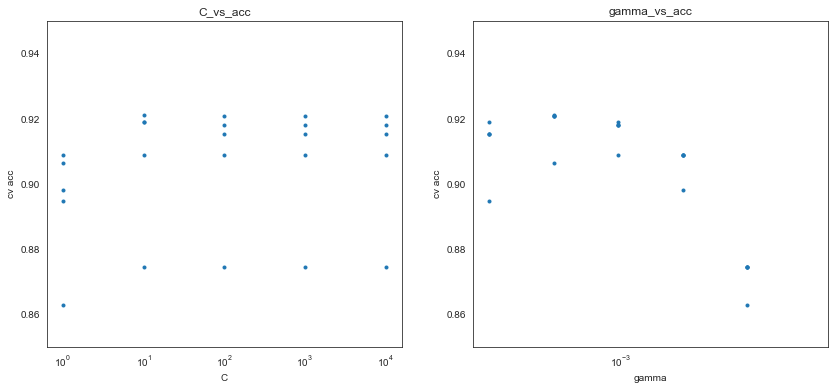

In [25]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.title('C_vs_acc')
plt.xlabel('C')
plt.ylabel('cv acc')
plt.xscale('log')
plt.ylim(0.85, 0.95)
_ = plt.plot( df_cv_estimator['param_svc__C'], df_cv_estimator['mean_test_score'], '.')

plt.subplot(1, 2, 2)
plt.title('gamma_vs_acc')
plt.xlabel('gamma')
plt.ylabel('cv acc')
plt.xscale('log')
plt.ylim(0.85, 0.95)
_ = plt.plot( df_cv_estimator['param_svc__gamma'], df_cv_estimator['mean_test_score'], '.')
plt.show()

### Test SVC Performance

We check the test accuracy and confusion matrix.

### One vs Rest

In [26]:
best_C = svc_gscv.best_params_['svc__C'] 
best_gamma = svc_gscv.best_params_['svc__gamma'] 

best_svc = SVC(C=best_C, 
               gamma=best_gamma, 
               probability=True,
               shrinking=False,
               decision_function_shape='ovr', 
              )

best_svc_pipe = Pipeline(steps=[('std_sc', StandardScaler()),
                                 ('svc', best_svc)])


best_svc_pipe.fit(X_train, y_train)
prob_pred_svc = cross_val_predict(best_svc_pipe, X_test, y_test, method='predict_proba', cv=skf, n_jobs=-1)
y_pred_svc = np.argmax(prob_pred_svc, axis=1)

ohc = OneHotEncoder(sparse=False)
y_ohc = ohc.fit_transform(y_test.reshape(-1, 1))

acc    = accuracy_score(y_test, y_pred_svc)
recall = recall_score(y_test, y_pred_svc, average='micro')
prec   = precision_score(y_test, y_pred_svc, average='micro') 
roc_auc = roc_auc_score(y_ohc, prob_pred_svc, multi_class='ovr') 

print("acc: %.3f\trecall: %.3f\tprecision: %.3f" % (acc, recall, prec))
print("\nconfusion matrix:\n", confusion_matrix(y_test, y_pred_svc))
print("auc: %.3f" % (roc_auc))

acc: 0.942	recall: 0.942	precision: 0.942

confusion matrix:
 [[719   0   1   2   1   4   7   0   1   0]
 [  0 839   3   2   1   4   1   0   1   0]
 [  4   2 727   8   8   0   5  13   4   3]
 [  0   0   7 707   0  14   1  13  10   5]
 [  0   0  11   0 698   0   5   4   3  16]
 [  4   1   2  18   4 609  13   6   8   4]
 [  5   1  11   0   4   8 685   4   1   0]
 [  3   7  11   3   7   1   0 719   2  18]
 [  3   5   7   8   6  17   1   6 674   3]
 [  5   4   8   5  19   4   0  18   6 688]]
auc: 0.997


### One vs One

In [27]:
best_C = svc_gscv.best_params_['svc__C'] 
best_gamma = svc_gscv.best_params_['svc__gamma'] 

best_svc = SVC(C=best_C, 
               gamma=best_gamma, 
               probability=True,
               shrinking=False,
               decision_function_shape='ovo', 
              )

best_svc_pipe = Pipeline(steps=[('std_sc', StandardScaler()),
                                 ('svc', best_svc)])


best_svc_pipe.fit(X_train, y_train)
prob_pred_svc = cross_val_predict(best_svc_pipe, X_test, y_test, method='predict_proba', cv=skf, n_jobs=-1)
y_pred_svc = np.argmax(prob_pred_svc, axis=1)


ohc = OneHotEncoder(sparse=False)
y_ohc = ohc.fit_transform(y_test.reshape(-1, 1))

acc    = accuracy_score(y_test, y_pred_svc)
recall = recall_score(y_test, y_pred_svc, average='micro')
prec   = precision_score(y_test, y_pred_svc, average='micro') 
roc_auc = roc_auc_score(y_ohc, prob_pred_svc, multi_class='ovr') 

print("acc: %.3f\trecall: %.3f\tprecision: %.3f" % (acc, recall, prec))
print("\nconfusion matrix:\n", confusion_matrix(y_test, y_pred_svc))
print("auc: %.3f" % (roc_auc))

acc: 0.939	recall: 0.939	precision: 0.939

confusion matrix:
 [[723   0   2   2   0   3   4   0   1   0]
 [  0 838   3   2   1   4   1   0   2   0]
 [  3   2 721   8   7   1   4  16  10   2]
 [  0   0   7 707   0  13   2   9  13   6]
 [  1   0   5   0 698   1   3   8   3  18]
 [  3   3   4  17   3 610  11   7   7   4]
 [  6   2   9   0   3   8 685   5   1   0]
 [  1   7  17   4   5   2   0 713   1  21]
 [  5   4   8  10   7  16   2   9 664   5]
 [  4   4   6   9  20   2   0  20   5 687]]
auc: 0.997


### Conclusions on the SVC classifier

Give here a discussion as complete as possible of your results 

## Comparing the MLP and SVC Classifiers

Discuss the respective performances considering the choices you have made for each model and possible improvements on your approach.  
Consider both classification results and training times.